# Data Quality and Model Explainability in Computer Vision with OpenVINO™ Toolkit

Understanding why computer vision models make certain predictions using data and model explainability can help us refine our models to be more efficient and performant. This tutorial demonstrates how to use data quality measurements and saliency maps to understand the predictions and performance of computer vision models during inference.
 
The specific techniques we will cover in this kit are:

**Data quality measurements**
- Inspect the properties of data corresponding to each label (e.g., Are all the cars appearing bigger in the frame of my data (because they’re near to the camera), or are there images of cars in a distance that are smaller, so my algorithm is able to detect both near and far cars)
- Check if the labels in the dataset are imbalanced, meaning that one label/class (“dog”, “person”) has much more data attributed to it than other labels (“cat”/”tree”).
- Check if bounding boxes are far from the label mean, meaning that the bounding boxes that were used are incorrect.

OpenVINO [datumaro](https://github.com/openvinotoolkit/datumaro/tree/develop) is a library for dataset management. We'll leverage code snippets from datumaro's tutorials, specifically on [data validation](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/11_validate.ipynb), to generate these data quality measurements. 

**Saliency maps**
- Explainability algorithms can be used to generate heatmaps or saliency maps, showing which parts of the imag  a object classification or detection model used to make a prediction.


**Credits:** We would like to acknowledge the authors and maintainers of the Datumaro Github repository, and the Ultralytics team for their fantastic tutorials/snippets on YOLOv8.

## Imports

We'll start by installing our requirements for this kit.

In [1]:
!pip install -r requirements.txt --upgrade


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Step 1: Download our dataset

In this step, we'll download the COCO 2017 dataset, focusing specifically on the object detection task with object segmentation output. Below, we run a few commands to fetch and unzip the dataset

In [29]:
from zipfile import ZipFile
import sys
import os
sys.path.append("..")
import utils
import glob

from pathlib import Path

data_out_dir = Path('coco_dataset')

if Path(data_out_dir).is_dir() is not True:
    DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
    TRAIN_ANNOTATIONS_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    PANOPTIC_ANNOTATIONS_URL = "http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip"
    
    utils.download_file(DATA_URL, directory=data_out_dir, show_progress=True)
    utils.download_file(TRAIN_ANNOTATIONS_URL, directory=data_out_dir, show_progress=True)
    utils.download_file(PANOPTIC_ANNOTATIONS_URL, directory=data_out_dir, show_progress=True)
    
    with ZipFile(data_out_dir / 'val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(data_out_dir / 'images')
        
    with ZipFile(data_out_dir / 'annotations_trainval2017.zip' , "r") as zip_ref:
        zip_ref.extractall(data_out_dir)
    
    with ZipFile(data_out_dir / 'panoptic_annotations_trainval2017.zip' , "r") as zip_ref:
        zip_ref.extractall(data_out_dir / 'annotations')

    for filename in glob.glob('coco_dataset/**/*_train2017.json', recursive=True):
        os.remove(filename)
else:
    print("COCO Dataset folder is already present. Proceeding with next steps.")

coco_dataset/val2017.zip:   0%|          | 0.00/778M [00:00<?, ?B/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

coco_dataset/panoptic_annotations_trainval2017.zip:   0%|          | 0.00/821M [00:00<?, ?B/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

## Step 2: Analyze the quality of the data

To start analyzing the quality of the data, we'll load in datumaro. Here, we'll import our local COCO dataseta and define our data subset as the 2017 validation data.

In [30]:
import datumaro as dm

dataset = dm.Dataset.import_from("coco_dataset", format="coco_instances")
subset = list(dataset.subsets().keys())[0]  # val2017

In [31]:
subset

'val2017'

In [32]:
def find_item_with_given_label_name(dataset, label_name):
    label_cats = dataset.categories()[dm.AnnotationType.label]
    for item in dataset:
        labels = {label_cats[ann.label].name for ann in item.annotations}
        if label_name in labels:
            print(f'ID: {item.id} has "{label_name}" label')

In [33]:
find_item_with_given_label_name(dataset, "car")

ID: 000000033759 has "car" label
ID: 000000478721 has "car" label
ID: 000000040083 has "car" label
ID: 000000477227 has "car" label
ID: 000000534394 has "car" label
ID: 000000019042 has "car" label
ID: 000000341921 has "car" label
ID: 000000279714 has "car" label
ID: 000000059386 has "car" label
ID: 000000023272 has "car" label
ID: 000000504415 has "car" label
ID: 000000171382 has "car" label
ID: 000000157928 has "car" label
ID: 000000513181 has "car" label
ID: 000000305695 has "car" label
ID: 000000082821 has "car" label
ID: 000000376625 has "car" label
ID: 000000093154 has "car" label
ID: 000000499181 has "car" label
ID: 000000404534 has "car" label
ID: 000000128372 has "car" label
ID: 000000054967 has "car" label
ID: 000000334371 has "car" label
ID: 000000429109 has "car" label
ID: 000000111086 has "car" label
ID: 000000466156 has "car" label
ID: 000000157756 has "car" label
ID: 000000031118 has "car" label
ID: 000000386210 has "car" label
ID: 000000220732 has "car" label
ID: 000000

In [34]:
dataset = dataset.clone().filter('/item/annotation[label="car" or label="bus" or label="train" or label="truck" or label="street sign" or label="road street" or label="stop sign" or label="traffic light" or label="license plate"]', filter_annotations=True)

In [35]:
find_item_with_given_label_name(dataset, "bus")

ID: 000000394275 has "bus" label
ID: 000000226154 has "bus" label
ID: 000000015440 has "bus" label
ID: 000000128372 has "bus" label
ID: 000000334371 has "bus" label
ID: 000000429109 has "bus" label
ID: 000000333745 has "bus" label
ID: 000000220732 has "bus" label
ID: 000000002006 has "bus" label
ID: 000000133819 has "bus" label
ID: 000000497867 has "bus" label
ID: 000000333402 has "bus" label
ID: 000000269632 has "bus" label
ID: 000000147223 has "bus" label
ID: 000000005037 has "bus" label
ID: 000000055167 has "bus" label
ID: 000000254814 has "bus" label
ID: 000000148508 has "bus" label
ID: 000000226802 has "bus" label
ID: 000000436738 has "bus" label
ID: 000000524850 has "bus" label
ID: 000000540414 has "bus" label
ID: 000000153011 has "bus" label
ID: 000000534673 has "bus" label
ID: 000000280710 has "bus" label
ID: 000000474452 has "bus" label
ID: 000000249219 has "bus" label
ID: 000000446206 has "bus" label
ID: 000000293324 has "bus" label
ID: 000000329614 has "bus" label
ID: 000000

In [36]:
def get_ids(dataset: dm.Dataset, subset: str):
    ids = []
    for item in dataset:
        if item.subset == subset:
            ids += [item.id]

    return ids


ids = get_ids(dataset, subset)
print("DatasetItem ids:", ids[:4])

DatasetItem ids: ['000000015335', '000000394940', '000000552775', '000000168974']


Let's start with briefly visualizing our data and the ground truth bounding boxes and semantic segmentation coming with the dataset.

/tmp/ipykernel_1087796/2783201660.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


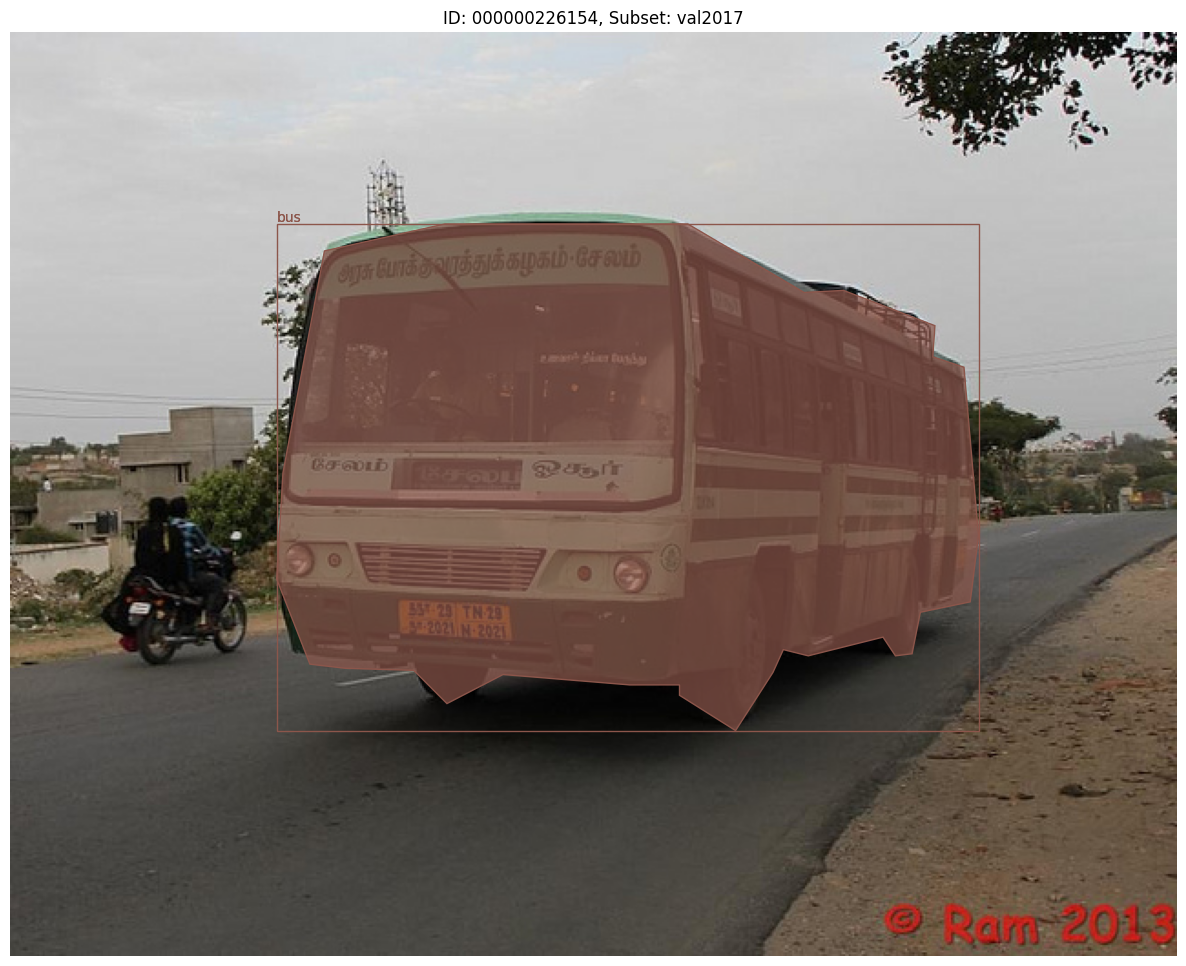

In [37]:
visualizer = dm.Visualizer(dataset, figsize=(16, 12), alpha=0.7)

fig = visualizer.vis_one_sample(ids[55], subset)
fig.show()

## Step 2: Create an automated data quality report
Via datumaro's Visualizer, we can now see the outputs on a few images from the data. Let's now take a look at creating a validation report.

In [38]:
from datumaro.plugins.validators import DetectionValidator

extra_args = {
    "few_samples_thr": 100,
    "imbalance_ratio_thr": 5,
    "far_from_mean_thr": 20.0,
}

validator = DetectionValidator(**extra_args)

#Defining a function to create a summary validation report of the data
def validate(dataset):
    reports = validator.validate(dataset)

    print("Validation report summary:", reports["summary"])

    error_cnt = {}
    warning_cnt = {}
    for report in reports["validation_reports"]:
        if report["severity"] == "error":
            type = report["anomaly_type"]
            if error_cnt.get(type) is None:
                error_cnt[type] = 1
            else:
                error_cnt[type] += 1
        if report["severity"] == "warning":
            type = report["anomaly_type"]
            if warning_cnt.get(type) is None:
                warning_cnt[type] = 1
            else:
                warning_cnt[type] += 1
    print("The number of errors per error type: ", error_cnt)
    print("The number of warnings per warning type: ", warning_cnt)

    return reports


reports = validate(dataset)

Validation report summary: {'errors': 3534, 'warnings': 4166, 'infos': 9}
The number of errors per error type:  {'UndefinedAttribute': 3534}
The number of warnings per warning type:  {'MissingAnnotation': 4091, 'LabelDefinedButNotFound': 74, 'FarFromLabelMean': 1}


## Step 3 Treat data errors (selected)

Looking deeper into the metadata of the MS-COCO datasset subset, we can pinpoint the UndefineAttribute errors are due to the attribute is_crowd not being defined in metadata. 

Let's try treating the UndefinedAttribute errors by rejecting these specific labels from annotations in the sample.

In [39]:
from datumaro.components.annotation import AnnotationType, LabelCategories

label_categories = dataset.categories().get(AnnotationType.label, LabelCategories())

for report in reports["validation_reports"]:
    if report["anomaly_type"] == "UndefinedAttribute":
        item = dataset.get(report["item_id"], report["subset"])
        for ann in item.annotations:
            for k in ann.attributes.keys():
                label_categories[ann.label].attributes.add(k)

reports = validate(dataset)

Validation report summary: {'errors': 0, 'warnings': 4166, 'infos': 32}
The number of errors per error type:  {}
The number of warnings per warning type:  {'MissingAnnotation': 4091, 'LabelDefinedButNotFound': 74, 'FarFromLabelMean': 1}


It looks like that specific category of issues is fixed! Let's now specifically look into the warnings section, and dive deeper there.

## Step 4: Visualize data warnings

Here, we'll define a sample function to visualize our data warnings.

In [40]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from datumaro.components.annotation import AnnotationType, LabelCategories

label_categories = dataset.categories().get(AnnotationType.label, LabelCategories())

#Defining a function to visualize label IDs
def visualize_label_id(item, label_id=None):
    img = item.media.data.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for ann in item.annotations:
        if not label_id:
            continue
        if ann.id == label_id:
            x, y, w, h = ann.get_bbox()
            label_name = label_categories[ann.label].name
            x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
            cv2.putText(img, label_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))

    plt.imshow(img)
    plt.axis("off")
    plt.show()

### 4.1 Imbalanced Labels

Let's start with imbalanced labels. The number of objects per label measures the distribution of the data objects across different categories or classes. We can review this metric to identify if the number of objects per label is skewed or uneven beyond expectations, in which case the data might not represent the real-world distribution of the categories.

There is an imbalance in the label distribution.


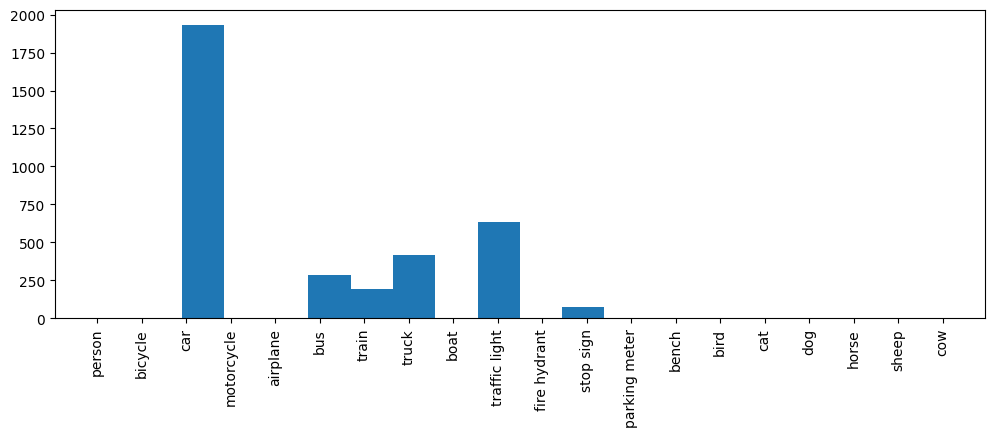

In [41]:
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "ImbalancedLabels":
        print(report["description"])

stats = reports["statistics"]

label_stats = stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name[:20], weights=label_counts[:20], bins=len(label_name[:20]))
plt.xticks(rotation="vertical")
plt.show()

Taking a look at the above plot, we can identify that there's a much higher number of labels corresponding to the "car" category compared to other labels. We also see a smaller number of labels to data allocated to the stop sign label for example, which implies that our downstream model performance could be lower on this particular category. 

If high performance on these categories with lower amounts of data is important to us for our use case, we may consider gathering and adding additional data for these categories as our next step. 

### 4.2 Missing Annotations

Data samples with missing annotations can be problematic for the performance of a model. Although being a part of the dataset, these data samples are completely invaluable due to missing annotations that the model cannot leverage for training, or for evaluation during inference.

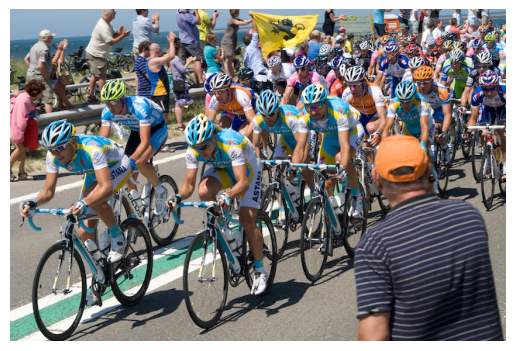

In [42]:
missing_annotations = []
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "MissingAnnotation":
        missing_annotations.append(dataset.get(report["item_id"], report["subset"]))

visualize_label_id(missing_annotations[55])

### 4.3 FarFromLabelMean

Far From Label Mean measures the variation of the size of bounding boxes objects in our dataset used for AI applications. 
We can visualize the object size corresponding to each label, including the overall height and width of objects in relation to each other.  

When annotating images, the ground truth bounding boxes are typically created to snap around individuals’ figures,  with all of the object size results being balanced.  

However, in certain cases, we can have anomalous bounding boxes that are too thin or too tall, and don't accurately capture the object as part of the dataset. 

Annotation '900300121242' in the item has a value of 'bounding box ratio(w/h)' that is too far from the label average. (mean of 'car' label: 1.67, got '29.29').


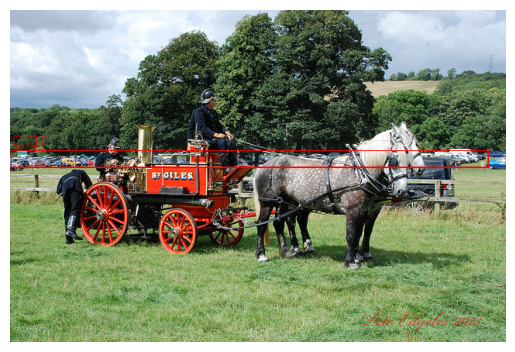

In [43]:
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "FarFromLabelMean":
        print(report["description"])
        item = dataset.get(report["item_id"], report["subset"])
        label_id = [int(s) for s in str.split(report["description"], "'") if s.isdigit()][0]
        visualize_label_id(item, label_id)

In some special cases like the above instance, we can pinpoint multiple issues: Here, not only is the bounding box stretched incorrectly, this is also not an image of a car! We could either manually delete this image, or adjust the ground truth annotation label and bounding box to make it usable.

## Generate a heatmap for model explainability

For many different use cases, we'll want to leverage optimized object detection models with a smaller model footprint and faster inference. But can we also add explainability to these optimized models? 

Let's explore this with using the OpenVINO™ YOLOv8 model FP16 model via the Ultralytics API. Ultralytics' YOLOv8 API provides convenient model exporting to different formats, including OpenVINO IR. model.export is responsible for the model conversion. We need to specify the format, and additionally, we could preserve dynamic shapes in the model. It would limit us to use CPU only, so we're not doing this. Also, we specify we want to use half-precision (FP16) to get better performance.

In [22]:
from ultralytics import YOLO

#Specify our models path
models_dir = Path('./model')
models_dir.mkdir(exist_ok=True)

DET_MODEL_NAME = "yolov8m"
det_model = YOLO(models_dir / f'{DET_MODEL_NAME}.pt')
label_map = det_model.model.names

# Load our Yolov8 object detection model
ov_model_path = Path(f"model/{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not ov_model_path.exists():
    # export model to OpenVINO format
    out_dir = det_model.export(format="openvino", dynamic=False, half=True)

model = YOLO('model/yolov8m_openvino_model/')

WARNING ⚠️ Ultralytics settings reset to defaults. This is normal and may be due to a recent ultralytics package update, but may have overwritten previous settings. 
View and update settings with 'yolo settings' or at '/home/ria/.config/Ultralytics/settings.yaml'
/home/ria/openvino_env/lib/python3.10/site-packages/ultralytics/yolo/utils/plotting.py:13: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.


Next, let's generate a heatmap with the Ultralytics YOLOv8 API and Intel OpenVINO.

For object classification and detection models, a **heatmap**, or **saliency map**, shows where a model is "focusing" on a certain part of the image to make a prediction/inference. Higher intensities of color indicate a greater focus than the model is placing on that part of the image, and cooler tones indicate a lower focus, pertaining to the detected object.

Let's consider an example of a sample video of cars, with footage from an aerial drone.

In [ ]:
#Source: https://docs.ultralytics.com/guides/heatmaps/#real-world-applications

from ultralytics import YOLO
from ultralytics.solutions import heatmap
import cv2

model = YOLO('model/yolov8m_openvino_model/')
cap = cv2.VideoCapture("Cars-FHD.mov")
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Video writer
video_writer = cv2.VideoWriter("heatmap_output.avi",
                               cv2.VideoWriter_fourcc(*'mp4v'),
                               fps,
                               (w, h))

# Init heatmap
heatmap_obj = heatmap.Heatmap()
heatmap_obj.set_args(colormap=cv2.COLORMAP_PARULA,
                     imw=w,
                     imh=h,
                     view_img=True,
                     shape="circle")

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break
    tracks = model.track(im0, persist=True, show=False)

    im0 = heatmap_obj.generate_heatmap(im0, tracks)
    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()

This snippet generates our heatmap for our optimized YOLOv8 model with the yellowish to blue areas indicating the focus of the model! Despite leveraging a model with smaller model size, we're still able to enable explainabiility for our optimized models.

The generated output is a video - we include a sample snippet from the video below!

![sample_snippet](https://github.com/openvinotoolkit/datumaro/assets/22090501/89ff7890-48c9-4e04-8b54-10bd9af4206f)